Epoch 1/500
1039/1039 [==============================] - 8s 4ms/step - loss: 0.0282 - mae: 0.0694 - val_loss: 0.0037 - val_mae: 0.0359 - lr: 0.0010
Epoch 2/500
1039/1039 [==============================] - 4s 4ms/step - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0024 - val_mae: 0.0285 - lr: 0.0010
Epoch 3/500
1039/1039 [==============================] - 5s 5ms/step - loss: 0.0027 - mae: 0.0300 - val_loss: 0.0023 - val_mae: 0.0299 - lr: 0.0010
Epoch 4/500
1039/1039 [==============================] - 4s 4ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 0.0018 - val_mae: 0.0246 - lr: 0.0010
Epoch 5/500
1039/1039 [==============================] - 4s 4ms/step - loss: 0.0018 - mae: 0.0246 - val_loss: 0.0015 - val_mae: 0.0223 - lr: 0.0010
Epoch 6/500
1039/1039 [==============================] - 5s 5ms/step - loss: 0.0015 - mae: 0.0226 - val_loss: 0.0017 - val_mae: 0.0227 - lr: 0.0010
Epoch 7/500
1039/1039 [==============================] - 4s 4ms/step - loss: 0.0014 - mae: 0.0217 - val_loss: 0.

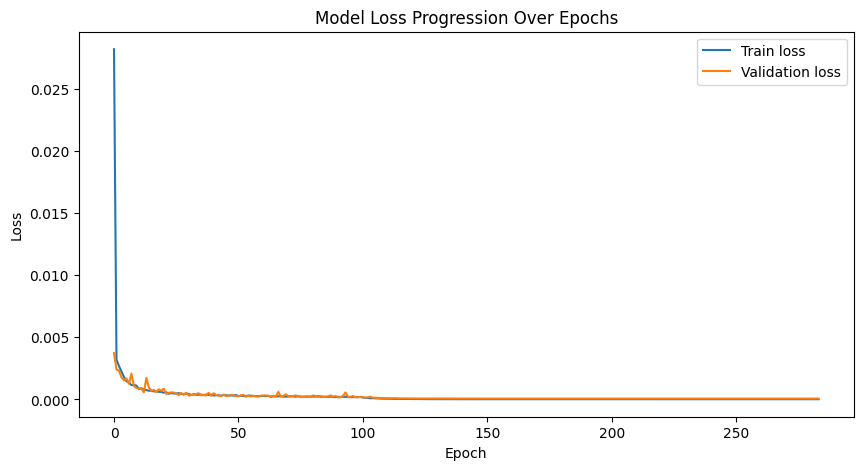

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from joblib import dump

# Load in dataset
df = pd.read_excel('Dragline Factors V1.xlsx')

# Selecting input and output columns from spreadsheet
input_cols = df.columns[0:8]  # A to H
output_cols = df.columns[32:39]  # AG to AM

# Preprocessing the input data
# Assuming categorical data in the first two columns and numerical in the rest
preprocessor = make_column_transformer(
    (OneHotEncoder(), ['Dragline', 'Method']),
    (StandardScaler(), input_cols[2:])
)

# Apply the preprocessing to input data
X = preprocessor.fit_transform(df[input_cols])
y = df[output_cols].values

dump(preprocessor, 'preprocessor.joblib')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a more complex neural network model with regularization
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_train.shape[1])
])

# Compile the model with a learning rate scheduler
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Add the scheduler to the list of callbacks
callbacks_list = [
    keras.callbacks.LearningRateScheduler(scheduler),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
] # 150 epochs without improvement stops the model to prevent overfitting

# Train the model with the scheduler and early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=callbacks_list
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)

# Make predictions (for new data or the test set)
predictions = model.predict(X_test)

# Select 20 samples for comparison
num_samples = 20
samples_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

# Prepare data for the DataFrame
data_for_df = []
for i in samples_indices:
    actual = y_test[i]
    predicted = predictions[i]
    error = np.abs(actual - predicted)
    data_for_df.append(np.concatenate([actual, predicted, error]))

# Column labels
labels = ['AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM']
columns = [f'Actual {label}' for label in labels] + \
          [f'Predicted {label}' for label in labels] + \
          [f'Error {label}' for label in labels]

# Create DataFrame
comparison_df = pd.DataFrame(data_for_df, columns=columns)

# Display the formatted DataFrame
print(comparison_df)

# Calculate the mean absolute error for the entire test set
mean_absolute_error = np.mean(np.abs(predictions - y_test), axis=0)
print(f"Mean Absolute Error on Test Data: {mean_absolute_error}")

# Visualize the training process
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss Progression Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#model.save('Dragline_Factors.h5')  # Saves to an HDF5 file
#from google.colab import files
#files.download('Dragline_Factors.h5')

# Download the preprocessor file
#files.download('preprocessor.joblib')


In [ ]:
from IPython.display import display

# Function to make predictions from an Excel file and return a formatted DataFrame
def make_predictions_from_excel(file_path, output_columns):
    # Load new data
    new_data_df = pd.read_excel(file_path)

    # Preprocess the new input data using the same preprocessor used during training
    new_X = preprocessor.transform(new_data_df)

    # Use the model to make predictions
    new_predictions = model.predict(new_X)

    # Round the predictions to match the original output formatting
    new_predictions_rounded = np.round(new_predictions, 6)

    # Create a DataFrame with the predictions and the specified output columns
    predictions_df = pd.DataFrame(new_predictions_rounded, columns=output_columns)

    # Return the DataFrame with predictions
    return predictions_df

# Column headings for the outputs as per your original dataset
output_columns = ['AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM']  # Replace with your actual column names

# Example usage:
new_data_file_path = 'DF_test_1.xlsx'
predictions_df = make_predictions_from_excel(new_data_file_path, output_columns)

# Print the DataFrame in a nicely formatted table
print("Predictions for the new input data:")
display(predictions_df)

1/1 [==============================] - 0s 18ms/step
Predictions for the new input data:


,AG,AH,AI,AJ,AK,AL,AM
0,0.088497,0.622510,0.615862,0.004849,0.001998,0.288891,0.327288
1,0.088939,0.623913,0.620352,0.003246,0.002201,0.289597,0.328378
2,0.088986,0.623094,0.620488,0.003380,0.001531,0.290238,0.328601
3,0.088868,0.622139,0.620057,0.004415,0.001447,0.290753,0.328689
4,0.089155,0.621321,0.620182,0.004395,0.001916,0.292003,0.329866
5,0.089291,0.620270,0.619838,0.003902,0.001393,0.293399,0.331047
6,0.089321,0.619113,0.619725,0.003399,0.001257,0.294934,0.332375
7,0.089202,0.617298,0.617977,0.002488,0.000122,0.296141,0.332986
8,0.089121,0.614219,0.613997,0.001184,-0.002055,0.297046,0.332699
9,0.091422,0.584832,0.581538,0.005710,0.000591,0.312764,0.345489
